In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Constants as Const
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [3]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.YamboCalculator(rr)
#code.global_options()

Initialize a Yambo calculator with scheduler direct


In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='fastnodes', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'fastnodes',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

# Analysis of the absorption spectrum in the equilibrium regime

We compute the equilibrium absorption spectrum in both the ip and BSE framework.

## IP analysis

The systems has 52 electrons and an equal numbers of full bands due to the SOC.

We compute the ip absorption spectrum for various k-samplings. In this way we test the effect of the $k$-sampling
on the shape of the absorption spectra.

All the computations are performed using the bands from 43 to 62. 

A scissor of 0.261 eV (as computed from the bands analysis) is used.

In [7]:
run_path = 'EQ_ABS'
kpoints = ['12x12x3','15x15x4','18x18x5']
direct_gap = 1.6 # eV

In [8]:
for k in kpoints:
    input_dir = 'DFT_analysis/kpoints_%s-nbnds_100.save'%k
    run_dir = os.path.join(run_path,k)
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)    

Executing command: cd EQ_ABS/12x12x3; p2y -I ../../DFT_analysis/kpoints_12x12x3-nbnds_100.save
Build the r_setup in the yambo_dir path EQ_ABS/12x12x3
Executing command: cd EQ_ABS/15x15x4; p2y -I ../../DFT_analysis/kpoints_15x15x4-nbnds_100.save
Build the r_setup in the yambo_dir path EQ_ABS/15x15x4
Executing command: cd EQ_ABS/18x18x5; p2y -I ../../DFT_analysis/kpoints_18x18x5-nbnds_100.save
Build the r_setup in the yambo_dir path EQ_ABS/18x18x5


In [9]:
elec_field = [1.,0.,0.]
BSEBands = [43,62]
energy_range = [0,6] # eV
energy_step = 500
damping = [0.05,0.05] # eV
scissor = 0.261

study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = os.path.join(run_path,k)
    inp = I.YamboInput('yambo -o b',folder=run_dir)
    inp.set_array_variables(BSEBands=BSEBands,BLongDir=elec_field)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BEnSteps=energy_step,KfnQP_E=[scissor,1.,1.])
    inp.set_scalar_variables(DIP_CPU='4.4.2',DIP_ROLEs='v.c.k',BS_CPU='8.4',BS_ROLEs= 'eh.k')
    idd = 'abs-ip-kpoints_%s'%(k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

Initialize a Dataset with 1 parallel tasks


In [10]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'EQ_ABS/12x12x3',
 'num_tasks': 1,
 'verbose': True,
 'skip': True,
 'input': {'args': 'yambo -o b',
  'folder': 'EQ_ABS/12x12x3',
  'filename': 'yambo.in',
  'arguments': ['bse', 'optics', 'photolum'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'BSENGexx': [38691.0, 'RL'],
   'BEnSteps': [500, ''],
   'BSKmod': 'IP',
   'BSEmod': 'resonant',
   'BSEprop': 'abs',
   'BSEdips': 'none',
   'BSEQptR': [[1, 1], ''],
   'BSEBands': [[43, 62], ''],
   'BEnRange': [[0, 6], 'eV'],
   'BDmRange': [[0.05, 0.05], 'eV'],
   'BLongDir': [[1.0, 0.0, 0.0], ''],
   'KfnQP_E': [[0.261, 1.0, 1.0], ''],
   'DIP_CPU': '4.4.2',
   'DIP_ROLEs': 'v.c.k',
   'BS_CPU': '8.4',
   'BS_ROLEs': 'eh.k'}},
 'name': 'abs-ip-kpoints_12x12x3'}

In [11]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of abs-ip-kpoints_12x12x3
Task [0] ended 
 
Run the task [1] 
Skip the run of abs-ip-kpoints_15x15x4
Task [1] ended 
 
Run the task [2] 
Skip the run of abs-ip-kpoints_18x18x5
Task [2] ended 
 


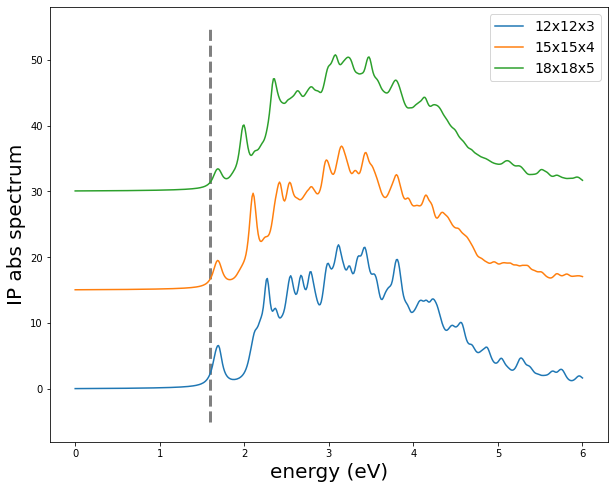

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kpoints):
    data = results[ind].data['eps_q1_IP']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,15*ind+eps_im,label=k)
ax.vlines(direct_gap,-5,55,linestyles='--',color='gray',linewidth=3)
ax.set_ylabel('IP abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We observe that the first peak reduces its magnitued by increasing the k sampling. Moreover, this peak
is not isolated since is due to vertical transitions from the region close to the K point.

We compare the spectra with the experimental data for what concerns both the absorption coeffcient
$\alpha = 2\omega Im(\epsilon(\omega))/c$ and the $Im(\epsilon(\omega)$. 

In [11]:
alpha_exp= 'Experiment/alpha.dat'
data = np.loadtxt(alpha_exp,delimiter=',').T
energy_alpha,alpha_exp = data

eps_exp = 'Experiment/BEAL_EPS2_eV.txt'
data = np.loadtxt(eps_exp).T
energy_eps,eps_exp = data

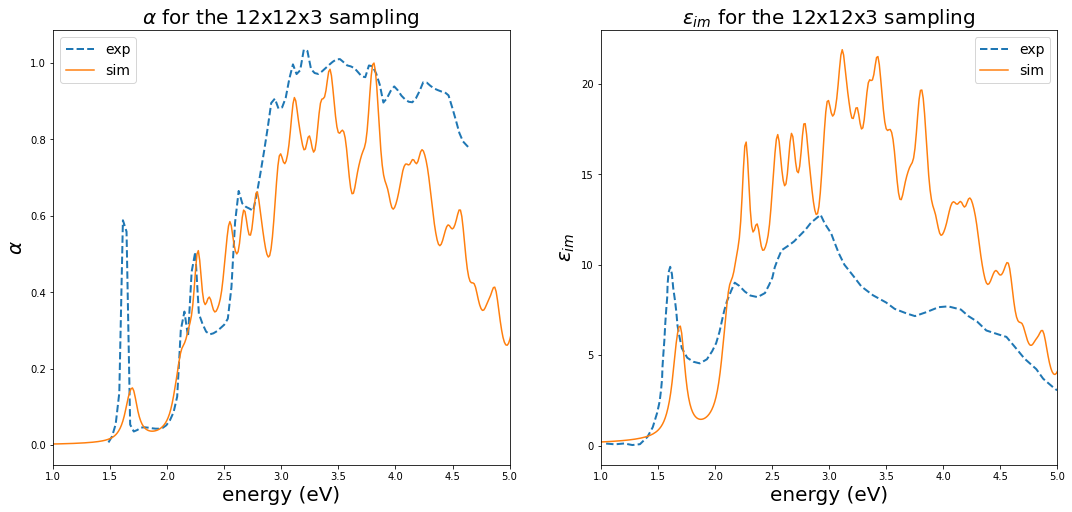

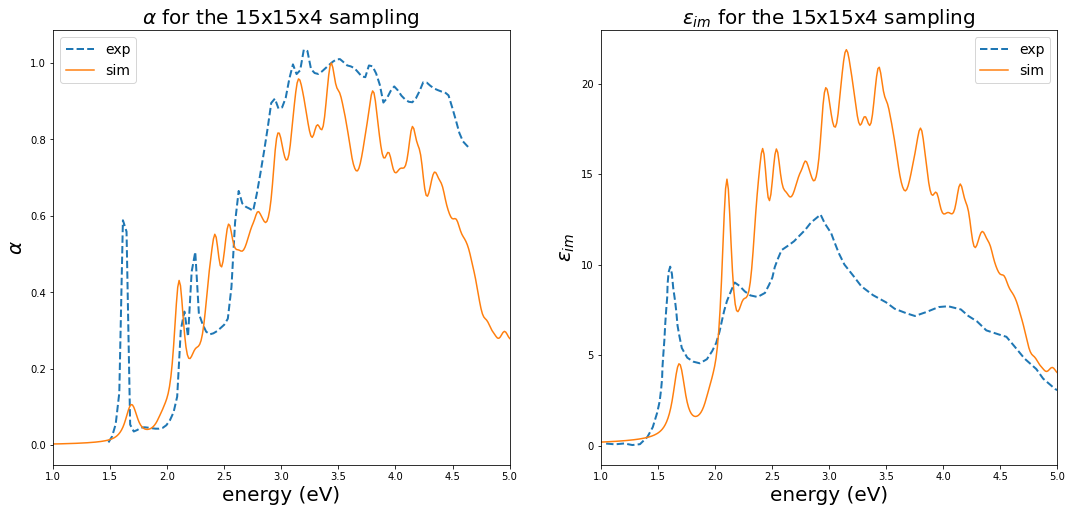

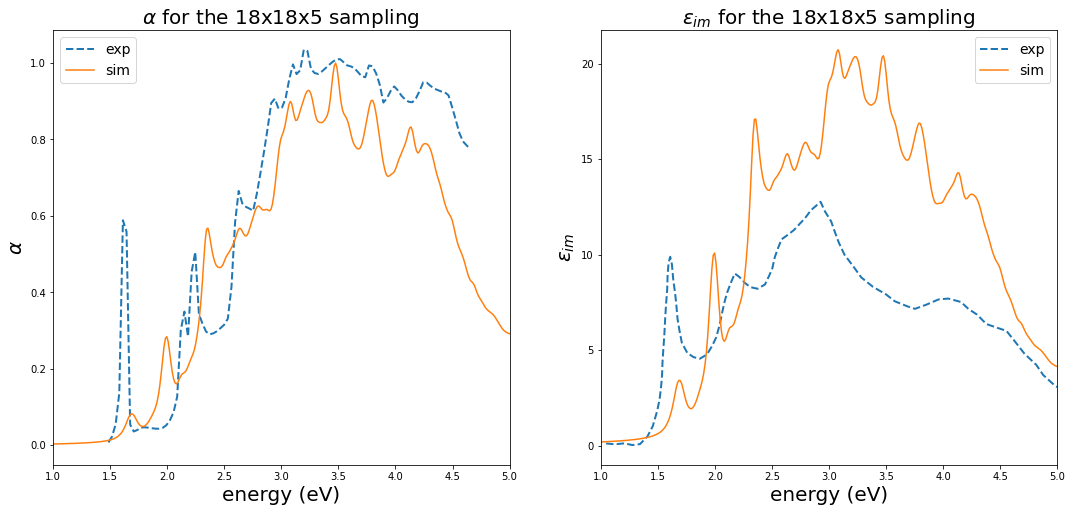

In [12]:
for ind,k in enumerate(kpoints):
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18, 8))

    ax[0].plot(energy_alpha,alpha_exp,label='exp',linestyle='--',linewidth=2)
    data = results[ind].data['eps_q1_IP']
    energy = data['energy']
    eps_im = data['eps_imag']
    alpha = eps_im*energy
    ax[0].plot(energy,alpha/max(alpha),label='sim') 
    ax[0].set_xlim(1,5)
    ax[0].set_ylabel(r'$\alpha$',size=20)
    ax[0].set_xlabel('energy (eV)',size=20)
    ax[0].set_title(r'$\alpha$ for the %s sampling'%kpoints[ind],size=20)
    ax[0].legend(fontsize=14)

    ax[1].plot(energy_eps,eps_exp,label='exp',linestyle='--',linewidth=2)
    data = results[ind].data['eps_q1_IP']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax[1].plot(energy,eps_im,label='sim') 
    ax[1].set_xlim(1,5)
    ax[1].set_ylabel(r'$\epsilon_{im}$',size=20)
    ax[1].set_xlabel('energy (eV)',size=20)
    ax[1].set_title(r'$\epsilon_{im}$ for the %s sampling'%kpoints[ind],size=20)
    ax[1].legend(fontsize=14)

## BSE Analysis

We analyze the equilibrium absorption spectrum in the BSE framework.

Also in this case we test the convergence of the spectrum w.r.t the $k$-points sampling.

### Computation of the static screening

We compute the static inverse dielectric function that is needed to compute the effective potential.

As a first step we adopt the parameters provided by the analysis performed by Andrea.

In [18]:
run_path = 'EQ_ABS'
kpoints = ['12x12x3','15x15x4','18x18x5']

In [19]:
for k in kpoints:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_100.save'%k
    run_dir = os.path.join(run_path,k)
    Tools.init_yambo_run_dir(Tools.make_p2y(source_dir),run_dir=run_dir)

SAVE folder DFT_analysis/kpoints_12x12x3-nbnds_100.save/SAVE already present. No operations performed.
SAVE folder already present in EQ_ABS/12x12x3. No operations performed.
SAVE folder DFT_analysis/kpoints_15x15x4-nbnds_100.save/SAVE already present. No operations performed.
SAVE folder already present in EQ_ABS/15x15x4. No operations performed.
SAVE folder DFT_analysis/kpoints_18x18x5-nbnds_100.save/SAVE already present. No operations performed.
SAVE folder already present in EQ_ABS/18x18x5. No operations performed.


In [20]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

NGsBlkXs = 200 # (RL) G size of the response function
NGsBlkXs_units = 'RL'
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = os.path.join(run_path,k)
    inp = I.YamboInput('yambo -X s',folder=run_dir)
    inp.set_array_variables(units=NGsBlkXs_units,NGsBlkXs=NGsBlkXs)
    inp.set_array_variables(BndsRnXs=BndsRnXs,LongDrXs=elec_field)
    #inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.4.4.2') # for 1 node on ismhpc (with 32 mpi and 1 omp per node)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.32') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    idd = 'em1s-ngsblkxs_%s-bndsrnxs_%s-kpoints_%s'%(NGsBlkXs,BndsRnXs[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

16 2
Initialize a Dataset with 1 parallel tasks


In [21]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'EQ_ABS/12x12x3',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'yambo -X s',
  'folder': 'EQ_ABS/12x12x3',
  'filename': 'yambo.in',
  'arguments': ['em1s'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'NGsBlkXs': [200, 'RL'],
   'Chimod': 'HARTREE',
   'XTermKind': 'none',
   'BndsRnXs': [[1, 100], ''],
   'LongDrXs': [[1.0, 0.0, 0.0], ''],
   'X_and_IO_ROLEs': 'q.g.k.c.v',
   'X_and_IO_CPU': '1.1.1.16.2',
   'SE_ROLEs': 'q.qp.b',
   'SE_CPU': '1.1.32'}},
 'name': 'em1s-ngsblkxs_200-bndsrnxs_100-kpoints_12x12x3'}

In [ ]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of em1s-ngsblkxs_200-bndsrnxs_100-kpoints_12x12x3

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        
Task [0] ended 
 
Run the task [1] 
run command: mpirun -np 32 yambo -F em1s-ngsblkxs_200-bndsrnxs_100-kpoints_15x15x4.in -J em1s-ngsblkxs_200-bndsrnxs_100-kpoints_15x15x4 -C em1s-ngsblkxs_200-bndsrnxs_100-kpoints_15x15x4
slurm submit:  cd EQ_ABS/15x15x4 ; sbatch job_em1s-ngsblkxs_200-bndsrnxs_100-kpoints_15x15x4.sh
computation em1s-ngsblkxs_200-bndsrnxs_100-kpoints_15x15x4 is running...
computation em1s-ngsblkxs_200-bndsrnxs_100-kpoints_15x15x4 ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_

### BSE calculations

In [85]:
run_path = 'EQ_ABS'
kpoints = ['12x12x3','15x15x4','18x18x5']
direct_gap = 1.6 # eV

We compute the bse kernel with the BSENGBlk = 50 RL for all the $k$-points samplings. We have tested that
this value provides converged results for the spectra.

In [73]:
BSENGBlk = 50 # (RL) G size of the response function
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]
BSEBands = {'12x12x3':[43,62],'15x15x4':[43,62],'18x18x5':[47,56]}
energy_range = [0,6] # eV
energy_step = 500
damping = [0.05,0.05] # eV
scissor = 0.261

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = os.path.join(run_path,k)
    inp = I.YamboInput('yambo -o b -k sex -y h',folder=run_dir)
    inp.set_array_variables(BSEBands=BSEBands[k],BLongDir=elec_field)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BEnSteps=energy_step,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(units='RL',BSENGBlk=BSENGBlk,BSENGexx=6293) #,FFTGvecs=6269
    inp.set_scalar_variables(DIP_CPU='4.4.2',DIP_ROLEs='v.c.k',BS_CPU='8.4',BS_ROLEs= 'eh.k')
    idd = 'bse-bsengblk_%s-bsebands_%s-%s-kpoints_%s'%(BSENGBlk,BSEBands[k][0],BSEBands[k][1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                 jobname=[idd,'em1s-ngsblkxs_200-bndsrnxs_100-kpoints_%s'%k,
                         'ndb_bse-bsengblk_50-bsebands_%s-%s'%(BSEBands[k][0],BSEBands[k][1])])

Initialize a Dataset with 1 parallel tasks


In [76]:
study.runs[2]

{'label': 'Dataset',
 'run_dir': 'EQ_ABS/18x18x5',
 'num_tasks': 1,
 'verbose': True,
 'skip': True,
 'input': {'args': 'yambo -o b -k sex -y h',
  'folder': 'EQ_ABS/18x18x5',
  'filename': 'yambo.in',
  'arguments': ['bse', 'optics', 'bss', 'photolum'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'BSENGexx': [6293, 'RL'],
   'BSENGBlk': [50, 'RL'],
   'BEnSteps': [500, ''],
   'BSHayTrs': [-0.02, ''],
   'BSKmod': 'SEX',
   'BSEmod': 'resonant',
   'BSSmod': 'h',
   'BSEprop': 'abs',
   'BSEdips': 'none',
   'BSEQptR': [[1, 1], ''],
   'BSEBands': [[47, 56], ''],
   'BEnRange': [[0, 6], 'eV'],
   'BDmRange': [[0.05, 0.05], 'eV'],
   'BLongDir': [[1.0, 0.0, 0.0], ''],
   'KfnQP_E': [[0.261, 1.0, 1.0], ''],
   'DIP_CPU': '4.4.2',
   'DIP_ROLEs': 'v.c.k',
   'BS_CPU': '8.4',
   'BS_ROLEs': 'eh.k'}},
 'jobname': ['bse-bsengblk_50-bsebands_47-56-kpoints_18x18x5',
  'em1s-ngsblkxs_200-bndsrnxs_100-kpoints_18x18x5',
  'ndb_bse-bsengblk_5

In [66]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of bse-bsengblk_50-bsebands_43-62-kpoints_12x12x3
Task [0] ended 
 
Run the task [1] 
Skip the run of bse-bsengblk_50-bsebands_43-62-kpoints_15x15x4
Task [1] ended 
 
Run the task [2] 
Skip the run of bse-bsengblk_50-bsebands_47-56-kpoints_18x18x5
Task [2] ended 
 


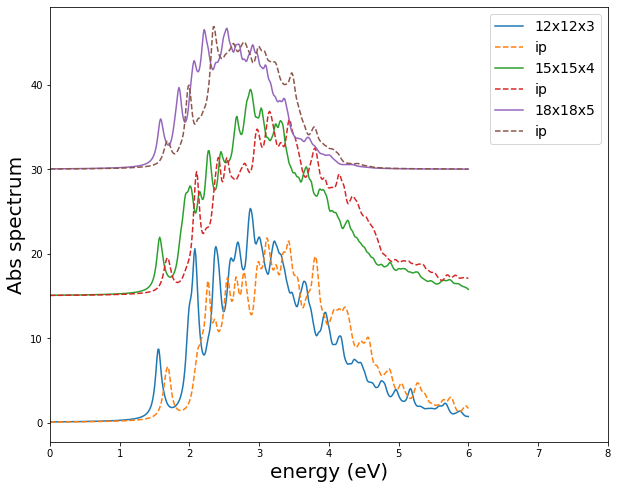

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kpoints):
    data = results[ind].data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    eps_o_im = data['eps_o_imag']
    ax.plot(energy,15*ind+eps_im,label='%s'%k) 
    ax.plot(energy,15*ind+eps_o_im,linestyle='--',label='ip') 
ax.set_xlim(0,8)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We compare the spectra with the experimental data for what concerns both the absorption coeffcient
$\alpha = 2\omega Im(\epsilon(\omega))/c$ and the $Im(\epsilon(\omega)$. 

In [68]:
alpha_exp= 'Experiment/alpha.dat'
data = np.loadtxt(alpha_exp,delimiter=',').T
energy_alpha,alpha_exp = data

eps_exp = 'Experiment/BEAL_EPS2_eV.txt'
data = np.loadtxt(eps_exp).T
energy_eps,eps_exp = data

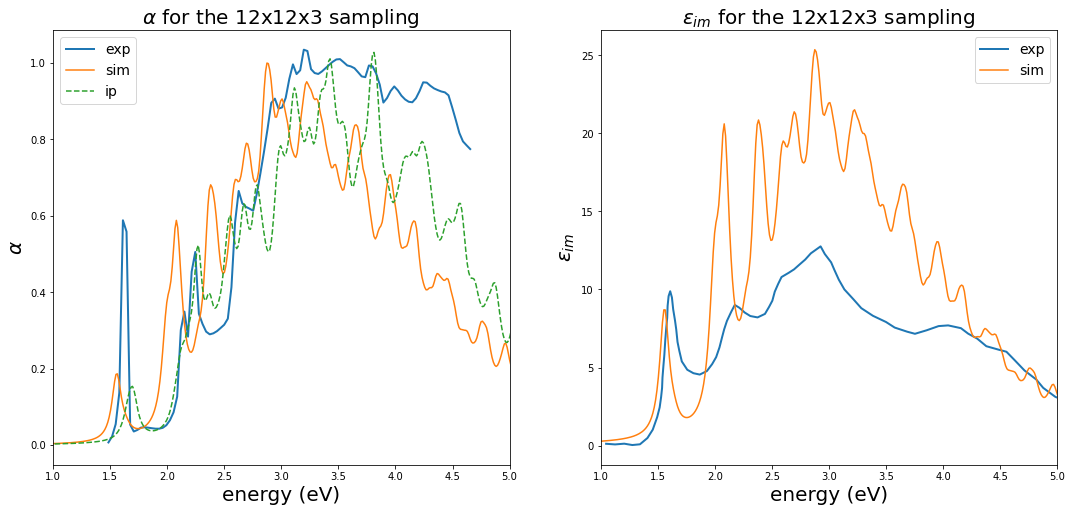

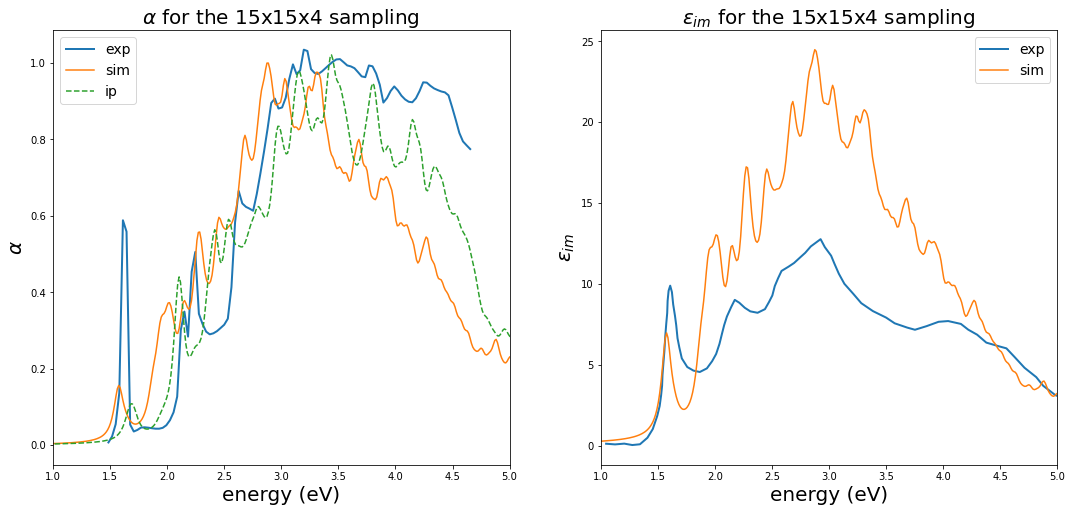

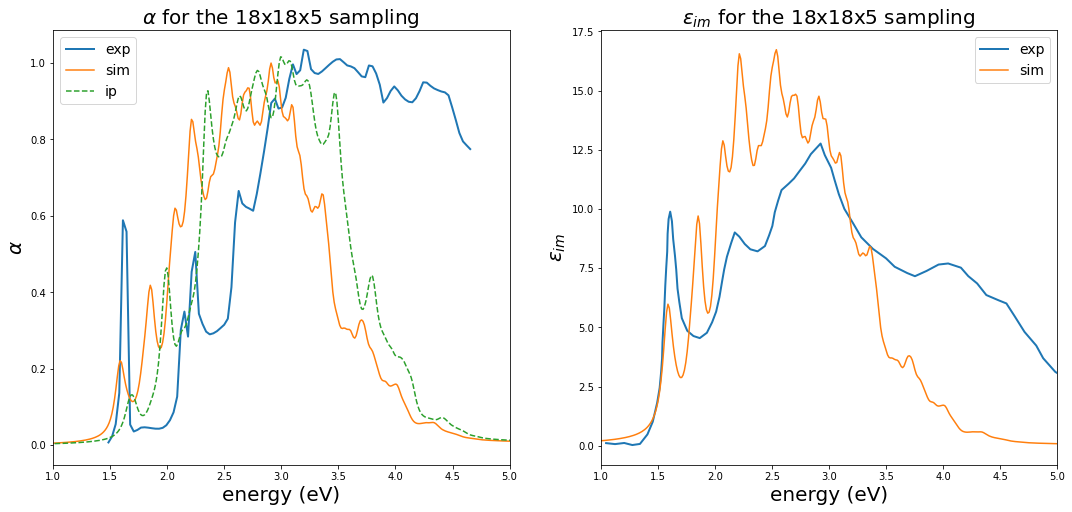

In [71]:
for ind,k in enumerate(kpoints):
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18, 8))

    ax[0].plot(energy_alpha,alpha_exp,label='exp',linestyle='-',linewidth=2)
    data = results[ind].data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    eps_o_im = data['eps_o_imag']
    alpha = eps_im*energy
    alpha_o = eps_o_im*energy
    ax[0].plot(energy,alpha/max(alpha),label='sim')
    ax[0].plot(energy,alpha_o/max(alpha),linestyle='--',label='ip')
    ax[0].set_xlim(1,5)
    ax[0].set_ylabel(r'$\alpha$',size=20)
    ax[0].set_xlabel('energy (eV)',size=20)
    ax[0].set_title(r'$\alpha$ for the %s sampling'%kpoints[ind],size=20)
    ax[0].legend(fontsize=14)

    ax[1].plot(energy_eps,eps_exp,label='exp',linestyle='-',linewidth=2)
    data = results[ind].data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax[1].plot(energy,eps_im,label='sim') 
    ax[1].set_xlim(1,5)
    ax[1].set_ylabel(r'$\epsilon_{im}$',size=20)
    ax[1].set_xlabel('energy (eV)',size=20)
    ax[1].set_title(r'$\epsilon_{im}$ for the %s sampling'%kpoints[ind],size=20)
    ax[1].legend(fontsize=14)

We observe that in this case the peak around 1.6 eV seems to be physical and not only due to the k sampling like in the IP framework.

We compute the value of the exciton binding energy

In [95]:
k = kpoints[1]

BSENGBlk = 50 # (RL) G size of the response function
BndsRnXs = [1,100] # Polarization function bands
elec_field = [1.,0.,0.]
BSEBands = {'12x12x3':[43,62],'15x15x4':[43,62],'18x18x5':[47,56]}
energy_range = [0,6] # eV
BEnSteps = 1000
damping = [0.05,0.05] # eV
BSSNEig = 40 # number of excitonic eigenvalues
BSSEnTarget = 1.5 # eV
scissor = 0.261

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

run_dir = os.path.join(run_path,k)
inp = I.YamboInput('yambo -o b -k sex -y s',folder=run_dir)
inp.set_array_variables(BSEBands=BSEBands[k],BLongDir=elec_field,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping,BSSEnTarget=BSSEnTarget)
inp.set_array_variables(BEnSteps=energy_step,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='RL',BSENGBlk=BSENGBlk,BSENGexx=6293)
inp.set_scalar_variables(DIP_CPU='4.4.2',DIP_ROLEs='v.c.k',BS_CPU='8.4',BS_ROLEs= 'eh.k')
inp.set_scalar_variables(BSEprop= 'abs esrt')
idd = 'bse-slepc-bsengblk_%s-bsebands_%s-%s-kpoints_%s'%(BSENGBlk,BSEBands[k][0],BSEBands[k][1],k)
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
jobname=[idd,'em1s-ngsblkxs_200-bndsrnxs_100-kpoints_%s'%k,
        'ndb_bse-bsengblk_50-bsebands_%s-%s'%(BSEBands[k][0],BSEBands[k][1])])

Initialize a Dataset with 1 parallel tasks


In [100]:
#study.runs[0]

In [97]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F bse-slepc-bsengblk_50-bsebands_43-62-kpoints_15x15x4.in -J "bse-slepc-bsengblk_50-bsebands_43-62-kpoints_15x15x4,em1s-ngsblkxs_200-bndsrnxs_100-kpoints_15x15x4,ndb_bse-bsengblk_50-bsebands_43-62" -C bse-slepc-bsengblk_50-bsebands_43-62-kpoints_15x15x4
slurm submit:  cd EQ_ABS/15x15x4 ; sbatch job_bse-slepc-bsengblk_50-bsebands_43-62-kpoints_15x15x4.sh
computation bse-slepc-bsengblk_50-bsebands_43-62-kpoints_15x15x4 is running...
computation bse-slepc-bsengblk_50-bsebands_43-62-kpoints_15x15x4 ended
Run performed in 16m-16s
Task [0] ended 
 


In [98]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([1.511597, 1.51306 , 1.540822, 1.574275, 1.580383, 1.581761,
       1.593964, 1.597253, 1.600751, 1.629415, 1.633286])

In [99]:
# 15X15X4
bind_eng = direct_gap-exc_eng[0]
bind_eng

0.08840300000000001

In [94]:
# 12X12X3
bind_eng = direct_gap-exc_eng[0]
bind_eng

0.10689400000000004